In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [ ]:
dados_bairros_jp = pd.read_csv(
    "bairros_joao_pessoa_clusterizacao.csv", encoding="utf-8"
)

print(dados_bairros_jp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nome_bairro                  65 non-null     object 
 1   populacao_total              65 non-null     int64  
 2   densidade_populacional       65 non-null     float64
 3   idh                          65 non-null     float64
 4   renda_per_capita_media       65 non-null     float64
 5   taxa_desemprego              65 non-null     float64
 6   taxa_analfabetismo           65 non-null     float64
 7   taxa_acesso_internet         65 non-null     float64
 8   taxa_mortalidade_infantil    65 non-null     float64
 9   expectativa_vida             65 non-null     float64
 10  taxa_criminalidade           65 non-null     float64
 11  numero_leitos_hospitais      65 non-null     float64
 12  taxa_moradias_irregulares    65 non-null     float64
 13  taxa_saneamento_basico

In [ ]:
print(dados_bairros_jp.head())

      nome_bairro  populacao_total  densidade_populacional    idh  \
0       Aeroclube            26654                 8886.04  0.671   
1       Água Fria            18795                 6395.83  0.914   
2       Altiplano             3860                 1223.53  0.766   
3     Alto do Céu             8390                 4232.51  0.797   
4  Alto do Mateus            32802                 4374.36  0.843   

   renda_per_capita_media  taxa_desemprego  taxa_analfabetismo  \
0                 4112.72            15.86                7.21   
1                 1263.16            13.75               16.73   
2                 2836.07            21.13                6.16   
3                 3661.58            21.72               19.34   
4                 4376.78            26.60                9.69   

   taxa_acesso_internet  taxa_mortalidade_infantil  expectativa_vida  \
0                 80.63                      39.86             70.92   
1                 74.40                     

In [ ]:
# Guardando a coluna de nomes dos bairros em um conjunto separado, pois ela não
# é relevante ao estudo, mas necessária pra organização
bairros_nomes = dados_bairros_jp["nome_bairro"]

bairros_dados = dados_bairros_jp.drop(columns=["nome_bairro"])

In [ ]:
# PRÉ-PROCESSAMENTO - Normalizando os dados:
scaler = StandardScaler()

x = scaler.fit_transform(bairros_dados)

In [ ]:
# PRÉ-PROCESSAMENTO - Aplicando o PCA para reduzir a complexidade dos dados:
pca = PCA(n_components=3, random_state=42)
x_pca = pca.fit_transform(x)

In [ ]:
# Testando várias quantidades de clusters, para ver qual gera o melhor
# silhouette score
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(x_pca)
    score = silhouette_score(x_pca, labels)
    sil_scores.append(score)
    print(f"GMM com {k} clusters – Silhouette Score: {score:.3f}")

best_k = k_range[sil_scores.index(max(sil_scores))]
print(f"\nMelhor k: {best_k}")

GMM com 2 clusters – Silhouette Score: 0.203
GMM com 3 clusters – Silhouette Score: 0.176
GMM com 4 clusters – Silhouette Score: 0.215
GMM com 5 clusters – Silhouette Score: 0.203
GMM com 6 clusters – Silhouette Score: 0.258
GMM com 7 clusters – Silhouette Score: 0.219
GMM com 8 clusters – Silhouette Score: 0.158
GMM com 9 clusters – Silhouette Score: 0.150
GMM com 10 clusters – Silhouette Score: 0.179

Melhor k: 6


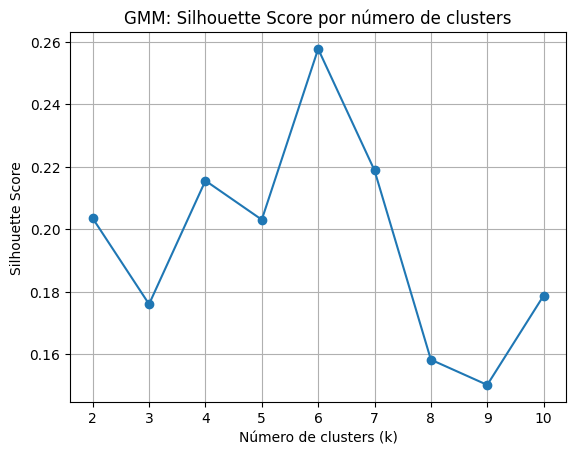

In [ ]:
# Gráfico de silhouette score de acordo com o número de clusters especificado
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("GMM: Silhouette Score por número de clusters")
plt.grid(True)
plt.show()

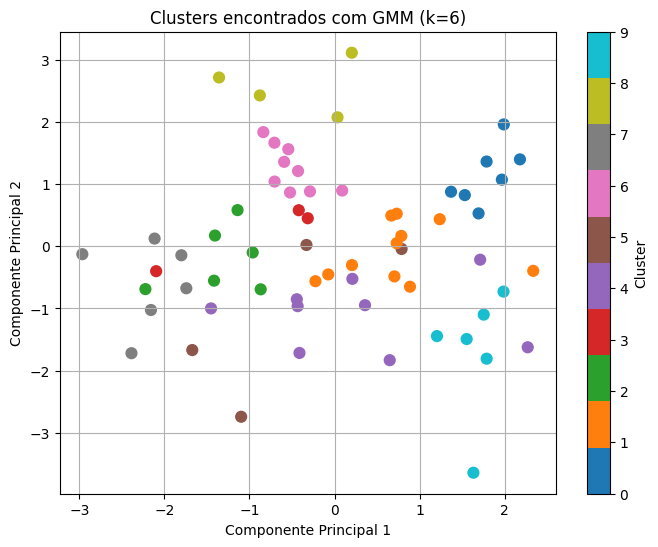

In [ ]:
# Visualizando os clusters
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=labels, cmap='tab10', s=60)
plt.title(f'Clusters encontrados com GMM (k={best_k})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# Testando diferentes tipos de covariância para encontrar o tipo de cluster que
# melhor se ajusta aos dados.
types = ['full', 'tied', 'diag', 'spherical']
for cov_type in types:
    gmm = GaussianMixture(
        n_components=best_k,
        covariance_type=cov_type,
        random_state=42
    )
    labels = gmm.fit_predict(x_pca)
    score = silhouette_score(x_pca, labels)
    print(f"covariance_type = {cov_type} → Silhouette Score: {score:.3f}")

covariance_type = full → Silhouette Score: 0.258
covariance_type = tied → Silhouette Score: 0.251
covariance_type = diag → Silhouette Score: 0.250
covariance_type = spherical → Silhouette Score: 0.275


In [ ]:
# Treinando o modelo final a partir dos dados encontrados
final_gmm = GaussianMixture(
    n_components=best_k,
    covariance_type='spherical',
    random_state=42
)
final_labels = final_gmm.fit_predict(x_pca)

# Adicionando coluna de clusters ao dataset
dados_bairros_jp["cluster"] = final_labels
print(dados_bairros_jp[["nome_bairro", "cluster"]])

                nome_bairro  cluster
0                 Aeroclube        5
1                 Água Fria        5
2                 Altiplano        1
3               Alto do Céu        2
4            Alto do Mateus        4
..                      ...      ...
60            Treze de Maio        3
61              Trincheiras        2
62  Valentina de Figueiredo        1
63                Varadouro        4
64          Varjão (Rangel)        3

[65 rows x 2 columns]


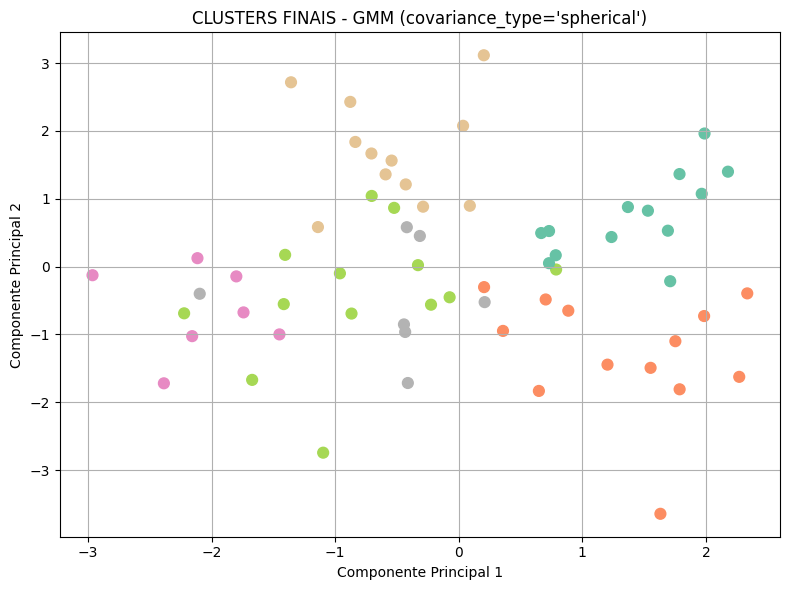

In [ ]:
# VISUALIZAÇÃO DOS CLUTERS APÓS OTIMIZAÇÕES
plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=final_labels, cmap="Set2", s=60)
plt.title("CLUSTERS FINAIS - GMM (covariance_type='spherical')")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

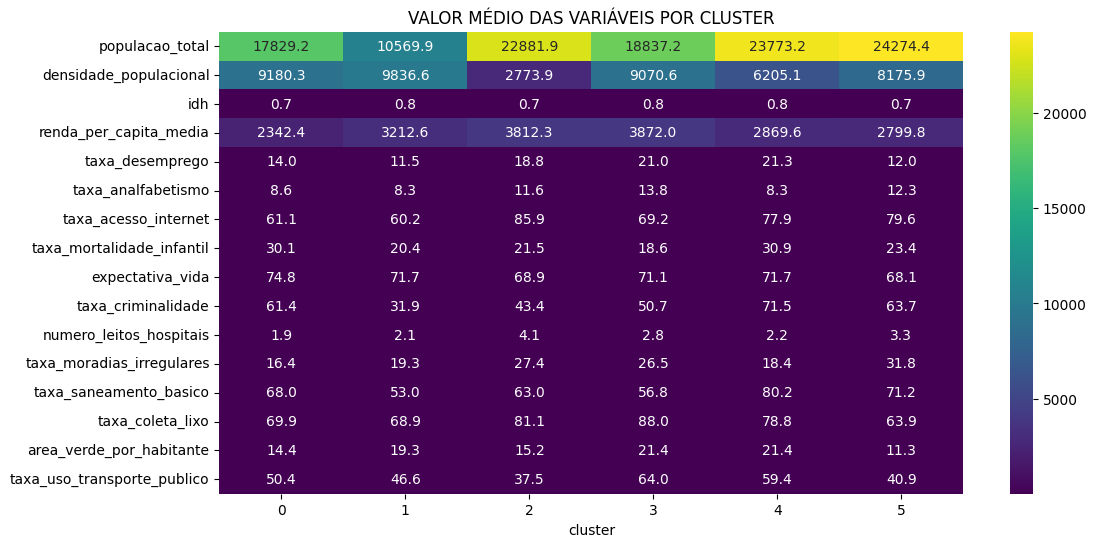

In [ ]:
# GRÁFICO - Valores médios dos valores das variáveis socioeconômicas de acordo
# com cada cluster
data_com_cluster = dados_bairros_jp.copy()
data_com_cluster["cluster"] = labels

cluster_means = data_com_cluster.groupby("cluster").mean(numeric_only=True)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, cmap="viridis", annot=True, fmt=".1f")
plt.title("VALOR MÉDIO DAS VARIÁVEIS POR CLUSTER")
plt.show()

In [ ]:
# DESCRIÇÃO DOS CLUSTERS
for cluster in sorted(data_com_cluster["cluster"].unique()):
    print(f"\nCluster {cluster} - {len(data_com_cluster[data_com_cluster['cluster'] == cluster])} bairros")
    print(data_com_cluster[data_com_cluster["cluster"] == cluster]["nome_bairro"].values)


Cluster 0 - 13 bairros
['Bessa' 'Cruz das Armas' 'Ernani Sátiro' 'Expedicionários' 'Grotão'
 'Ipês' 'Jardim Oceania' 'Mandacaru' 'Mangabeira' 'Mussuré' 'Oitizeiro'
 'Penha' 'Portal do Sol']

Cluster 1 - 13 bairros
['Altiplano' 'Castelo Branco' 'Costa e Silva' 'Distrito Industrial'
 'Funcionários' 'Gramame' 'Indústrias' 'João Paulo II' 'Mumbaba'
 'Padre Zé' 'Róger' 'Tambaú' 'Valentina de Figueiredo']

Cluster 2 - 7 bairros
['Alto do Céu' 'Costa do Sol' 'Jaguaribe' 'José Américo' 'Manaíra'
 'Paratibe' 'Trincheiras']

Cluster 3 - 13 bairros
['Cabo Branco' 'Cidade dos Colibris' 'Cuiá' 'Ilha do Bispo'
 'Jardim Cidade Universitária' 'Miramar' 'Muçumagro'
 'Planalto da Boa Esperança' 'São José' 'Tambauzinho' 'Torre'
 'Treze de Maio' 'Varjão (Rangel)']

Cluster 4 - 12 bairros
['Alto do Mateus' 'Bairro dos Estados' 'Bancários' 'Barra de Gramame'
 'Brisamar' 'Centro' 'Cristo Redentor' 'Estados' 'Jardim São Paulo'
 'João Agripino' 'Tambiá' 'Varadouro']

Cluster 5 - 7 bairros
['Aeroclube' 'Água F

In [ ]:
# SALVANDO RESULTADOS
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

joblib.dump(final_gmm, os.path.join(output_folder, "modelo_gmm_bairros.pkl"))
joblib.dump(scaler, os.path.join(output_folder, "scaler.pkl"))
joblib.dump(pca, os.path.join(output_folder, "pca.pkl"))
joblib.dump(bairros_nomes, os.path.join(output_folder, "nomes_bairros.pkl"))
dados_bairros_jp.to_csv("results/bairros_jp_clusterizados.csv", index=False)